In [15]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [16]:
# Load the dataset
df = pd.read_csv('Data Processing/Processed_combined.csv')

In [17]:
print(df)

                                      Transcribed text           label
0    make video embarrassing behavior normal person...      well-being
1    machine garden thing day sun today water tomor...      well-being
2    biggest paradigm shift made happiness skill mu...      well-being
3    happiness emotional response outcome win effec...      well-being
4    mojo save ditch video tip work tip happiness h...      well-being
..                                                 ...             ...
179  hey today talk project basically create stamp ...  non-well-being
180  guy today gon na living gon na workday hour lo...  non-well-being
181  um today gon na give honest review book read r...  non-well-being
182  jujutsu kaisen famous manga anime show heard m...  non-well-being
183  harry potter massive movie franchise based boo...  non-well-being

[184 rows x 2 columns]


In [18]:
# Clean the dataset by dropping rows with NaN values in 'Transcribed text'
df_cleaned = df.dropna(subset=['Transcribed text'])

In [19]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned['Transcribed text'], df_cleaned['label'], test_size=0.3, random_state=42
)

# Vectorize the text data into a bag-of-words model
vectorizer = CountVectorizer(stop_words='english')  # Drop stopwords in English
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize and train a Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=20, max_leaf_nodes=9, random_state=42)
classifier.fit(X_train_vectorized, y_train)

# Predict the labels for the test set
predictions = classifier.predict(X_test_vectorized)

# Evaluate the classifier
classification_rep = classification_report(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Classification Report:\n", classification_rep)
print("Accuracy:", accuracy)

# Extract feature importances
feature_importances = classifier.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Map feature importances to their corresponding words
feature_importance_dict = {word: importance for word, importance in zip(feature_names, feature_importances)}

# Sort the words by their feature importance
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Calculate word counts for each label
X_vectorized = vectorizer.transform(df_cleaned['Transcribed text'])  # Use the cleaned dataset
word_counts_sum = pd.DataFrame.sparse.from_spmatrix(
    X_vectorized, index=df_cleaned.index, columns=vectorizer.get_feature_names_out()
).groupby(df_cleaned['label']).sum()

# Display feature importances with counts
feature_importance_output = {}
for label in word_counts_sum.index:
    label_features = []
    print(f'\nLabel: {label}')
    for word, importance in sorted_feature_importances[:20]:  # Top 20 words
        if word in word_counts_sum.columns:
            count = word_counts_sum.loc[label, word]
            label_features.append((word, count, importance))
            print(f"{word}: Count: {count}, Importance: {importance}")
    feature_importance_output[label] = label_features

Classification Report:
                 precision    recall  f1-score   support

non-well-being       0.84      0.64      0.73        25
    well-being       0.75      0.90      0.82        30

      accuracy                           0.78        55
     macro avg       0.80      0.77      0.77        55
  weighted avg       0.79      0.78      0.78        55

Accuracy: 0.7818181818181819

Label: non-well-being
happiness: Count: 4, Importance: 0.025407435451642358
drop: Count: 30, Importance: 0.02177237646129926
energy: Count: 2, Importance: 0.020784622055794354
equation: Count: 9, Importance: 0.020422620453147404
experience: Count: 43, Importance: 0.01981897563460657
constantly: Count: 2, Importance: 0.0189039881940275
click: Count: 31, Importance: 0.018313120462482402
friend: Count: 38, Importance: 0.016561365616121503
total: Count: 18, Importance: 0.014621735332328325
person: Count: 56, Importance: 0.013626034852703889
player: Count: 37, Importance: 0.012856490138260363
knowing: Cou

In [20]:
# Check the number of trees in the Random Forest
num_trees = len(classifier.estimators_)
print(f"Number of trees in the Random Forest: {num_trees}")

# Calculate the average number of leaves per tree
num_leaves = [estimator.get_n_leaves() for estimator in classifier.estimators_]
average_leaves = np.mean(num_leaves)
print(f"Average number of leaves per tree: {average_leaves}")


Number of trees in the Random Forest: 20
Average number of leaves per tree: 9.0


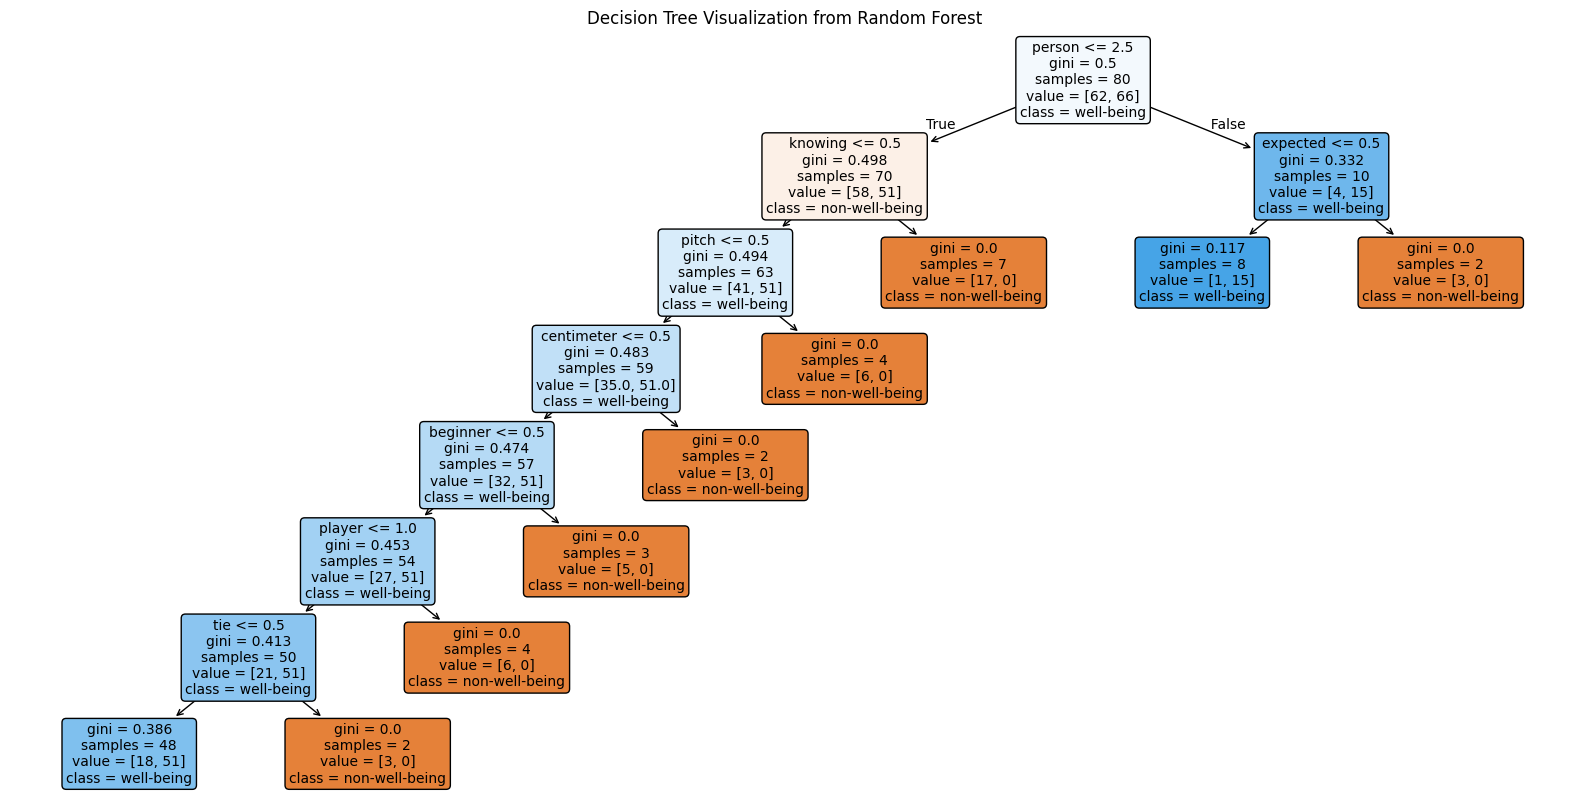

In [21]:
from sklearn.tree import plot_tree

# Extract a single tree from the Random Forest
single_tree = classifier.estimators_[1]  # You can select any tree by changing the index

# Set up a plot to visualize the tree
plt.figure(figsize=(20, 10))
plot_tree(
    single_tree,
    feature_names=vectorizer.get_feature_names_out(),  # Use feature names from the vectorizer
    class_names=classifier.classes_,  # Class labels
    filled=True,  # Color the nodes for better visualization
    rounded=True,  # Use rounded boxes
    fontsize=10  # Adjust font size
)
plt.title("Decision Tree Visualization from Random Forest")
plt.show()


X_test_dense shape: (55, 7609)
SHAP values shape: (55, 7609, 2)
row_to_explain shape: (7609,)


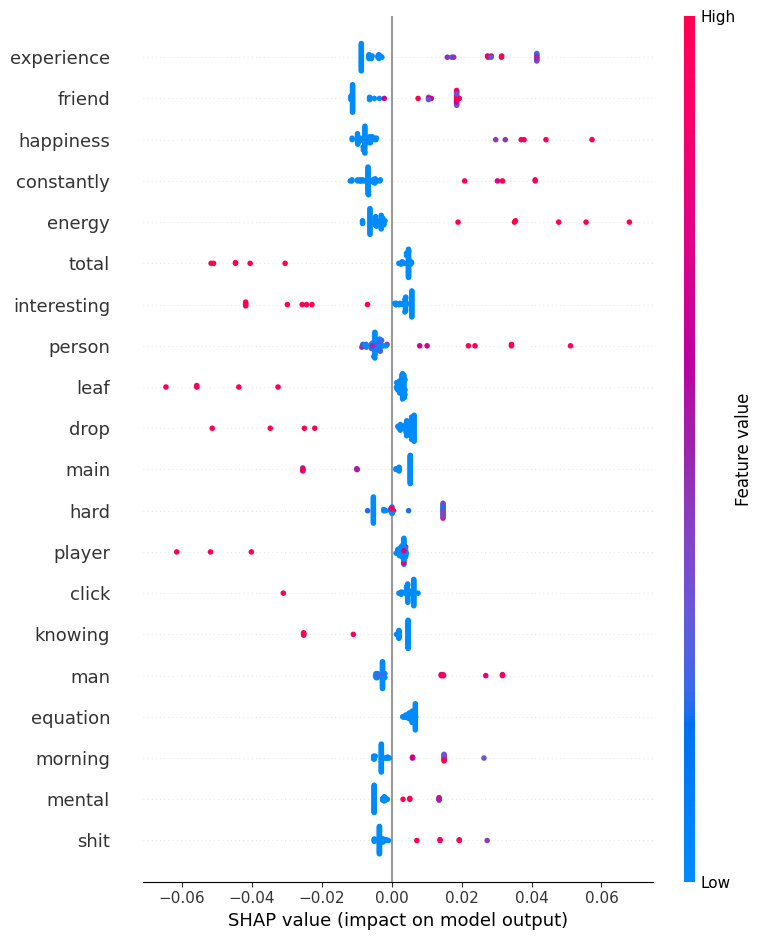

In [27]:
import shap
import numpy as np

# Convert sparse to dense
X_test_dense = X_test_vectorized.toarray()

# Ensure shape is (55, 7609)
print("X_test_dense shape:", X_test_dense.shape)
assert X_test_dense.shape[0] == 55, "Number of test samples should be 55"
assert X_test_dense.shape[1] == 7609, "Number of features should be 7609"

# Get feature names and ensure length matches
feature_names = vectorizer.get_feature_names_out()
assert len(feature_names) == X_test_dense.shape[1], "Feature length mismatch!"
feature_names = list(feature_names)

# Use the newer SHAP Explainer interface
explainer = shap.Explainer(classifier, feature_names=feature_names)

# Get the SHAP values
# For newer versions of SHAP, explainer returns a Explanation object
shap_values = explainer(X_test_dense)

# shap_values.values should have the shape (55, 7609, n_classes)
# In binary classification, n_classes = 2
print("SHAP values shape:", shap_values.values.shape)  # Expect (55, 7609, 2)

# If you prefer to work with the old shap_values format:
# shap_values.values[:,:,0] corresponds to class 0
# shap_values.values[:,:,1] corresponds to class 1
# For force_plot and summary_plot, pick the desired class slice:
class_index = 1

row_to_explain = X_test_dense[0]  # shape (7609,)
print("row_to_explain shape:", row_to_explain.shape)

# Force plot for one sample
shap.force_plot(
    base_value=explainer.expected_value[class_index],
    shap_values=shap_values.values[0,:,class_index],
    features=row_to_explain,
    feature_names=feature_names
)

# Summary plot
shap.summary_plot(shap_values.values[:,:,class_index], X_test_dense, feature_names=feature_names)


In [23]:
print(f"SHAP values shape (class 0): {shap_values[0].shape}")
print(f"SHAP values shape (class 1): {shap_values[1].shape}")
print(f"X_test_dense shape: {X_test_dense.shape}")
print(f"Feature names length: {len(feature_names)}")


SHAP values shape (class 0): (7609, 2)
SHAP values shape (class 1): (7609, 2)
X_test_dense shape: (55, 7609)
Feature names length: 7609


### Analysis
- 80% accuracy, reasonably good performance 
For non-well-being
- precision 77%
- recall 80%, ability to capture non wellbeing text in predictions
- f1 score: 78%

For well-being
- precision 83%
- recall 80%
- f1 score 81%

Key words in well-being
- happy
- feeling 
- mental

Non-well-being
- bad
- sad 